In [3]:
import math
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from naloga import NeuralNetwork, tf, mnist, delta, deep_Dream, truncated_normal, sigmoid

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# plt.rcParams["figure.figsize"] = (15,5)
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set2.colors)

In [4]:
## load data
(train_img, train_lab), (test_img, test_lab) = mnist.load_data()
end_train = train_img
end_test = test_img 

Image label:  9


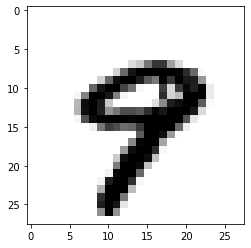

In [5]:
## Display N-th element from the training set and its label
element = 9

print("Image label: ", test_lab[element])
plt.imshow(test_img[element], cmap='gray_r')
plt.show()
# plt.savefig("element{}.png".format(element))

In [6]:
## reshape images and normalize data
train_img = np.asfarray(train_img.reshape((-1,784))) / 255.
test_img = np.asfarray(test_img.reshape((-1,784))) / 255.
train_lab = np.asfarray(train_lab)
test_lab = np.asfarray(test_lab)

In [7]:
## display number of occurrences of each digit in training and test set
print("digit\ttrain\ttest")
for i in range(10):
    print(i, np.sum(train_lab==i), np.sum(test_lab==i), sep='\t')


digit	train	test
0	5923	980
1	6742	1135
2	5958	1032
3	6131	1010
4	5842	982
5	5421	892
6	5918	958
7	6265	1028
8	5851	974
9	5949	1009


In [9]:
## transform data into one-hot representation
train_onehot = tf.one_hot(train_lab, depth=10)
test_onehot = tf.one_hot(test_lab, depth=10)

_______________________________________________________

In [10]:
## load neural network
shape = [784, 50, 10]
mu = 0.01

ANN = NeuralNetwork(network_structure=shape, learning_rate=mu, activation_function=sigmoid, bias=None)

In [8]:
## train the network
ep = 3
weights, out = ANN.train(data_array = train_img, labels_one_hot_array = train_onehot, epochs=ep, intermediate_results=False)

In [9]:
## evaluate
## train
TRAIN = ANN.evaluate(train_img, train_lab)
train_accuracy = TRAIN[0]/(TRAIN[0] + TRAIN[1])
print("Train accuracy: ", train_accuracy)

## test
TEST = ANN.evaluate(test_img, test_lab)
test_accuracy = TEST[0]/(TEST[0] + TEST[1])
print("Test accuracy: ", test_accuracy)

Train accuracy:  0.9270333333333334
Test accuracy:  0.9281


It thinks it's: 6, but it's actualy 4.


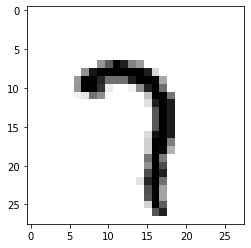

In [14]:
corrects, wrongs, err_correct, err_guess, truth, all_img = TEST

## display a random falsely identified digit 
index = random.randint(0, len(err_correct) - 1)
element = err_correct[index]

print("It thinks it's: {}, but it's actualy {}.".format(err_guess[index], int(test_lab[element])) )
plt.imshow(end_test[element], cmap='gray_r')
plt.show()

In [15]:
## train the network at different epochs
eps = np.asarray(range(1,11))
out_epochs = open("grafi/epohe.txt", 'a')
print("#epochs\ttrain_acc\ttest_acc", file=out_epochs)
for ep in eps:
    weights, out = ANN.train(data_array = train_img, labels_one_hot_array = train_onehot, epochs=ep, intermediate_results=False)

    TRAIN = ANN.evaluate(train_img, train_lab)
    train_accuracy = TRAIN[0]/(TRAIN[0] + TRAIN[1])

    TEST = ANN.evaluate(test_img, test_lab)
    test_accuracy = TEST[0]/(TEST[0] + TEST[1])

    print(ep, train_accuracy, test_accuracy, sep='\t', file=out_epochs, flush=True)

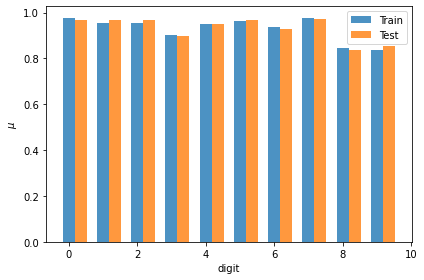

In [10]:
## plot some nice graphs
train_missed = [1-TRAIN[3].count(i)/TRAIN[5].count(i) for i in range(10)]
test_missed = [1-TEST[3].count(i)/TEST[5].count(i) for i in range(10)]

# create bar chart 
fig, ax = plt.subplots()
x = np.asarray(range(10))
bar_width = 0.35
opacity = 0.8

bar1 = plt.bar(x, train_missed, bar_width, alpha=opacity, label='Train')
bar2 = plt.bar(x + bar_width, test_missed, bar_width, alpha=opacity, label='Test')

plt.xlabel('digit')
plt.ylabel('$\mu$')
plt.legend()

plt.tight_layout()
plt.show()

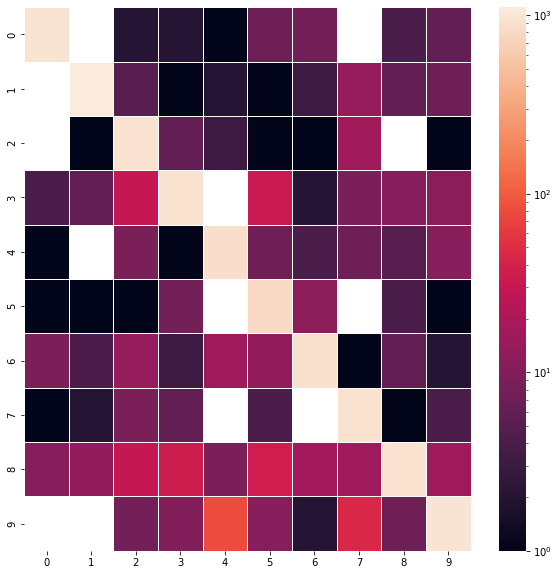

In [11]:
## Heatmap of digits
matrix1 = np.zeros((10,10), dtype='int')
matrix2 = np.zeros((10,10), dtype='int')
for i in range(len(TRAIN[5])):
    I = int(TRAIN[5][i])
    J = int(train_lab[i])
    matrix1[I, J] += 1

for i in range(len(TEST[5])):
    K = int(TEST[5][i])
    L = int(test_lab[i])
    matrix2[K, L] += 1

plt.figure(figsize=(10,10))
sns.heatmap(matrix2, annot=False,  linewidths=.5, norm=LogNorm())
plt.show()

In [14]:
## accuracy while traingin
shape = [784, 50, 10]
eks = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

tab = []
for eta in eks:
    ANN = NeuralNetwork(network_structure=shape, learning_rate=eta, activation_function=sigmoid, bias=None)
    weights, out = ANN.train(train_img, train_onehot, epochs=1, intermediate_results=False)

    length = len(out)//1000
    learning = np.asarray([np.average(out[i*1000:(i+1)*1000]) for i in range(length)])
    tab = np.vstack(tab, learning)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


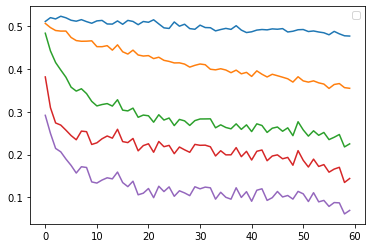

In [22]:
tab = np.array(tab)

x = np.asarray(range(len(out)//1000))
y0 = tab[0]

plt.plot(x, tab[0])
plt.plot(x, tab[1])
plt.plot(x, tab[2])
plt.plot(x, tab[3])
plt.plot(x, tab[4])
plt.show()

____________
Let's fall into deep dream

In [21]:
shape = [784, 80, 10]
eta = 0.01
ANN = NeuralNetwork(network_structure=shape, learning_rate=eta, activation_function=sigmoid, bias=None)
weights, out = ANN.train(train_img, train_onehot, epochs=1, intermediate_results=False)

In [22]:
def deep_Dream(y_0, target_vector):
    error = 5
    N_it = 1
    app = []
    while(error > 0.01 and N_it <= 3e6):
        h_0 = ANN.run(y_0.T, dream=True)
        error = np.linalg.norm(h_0[len(h_0)-1]-target_vector)
        app.append(error)
        #print(error)
        delta1 = delta(2, 0, weights, h_0, target_vector)
        prod = 0.01*np.dot(delta1, weights[0])
        y_0 += prod.T
        N_it += 1
    return y_0, app

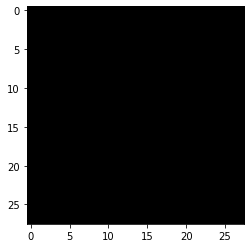

In [23]:
## starting canvas is all black
y_0 = np.ones((784, 1))
img = y_0.reshape((28, 28))

plt.figure(3)
plt.imshow(img, vmin=0, vmax=1, cmap="Greys")

## start dreaming
index = 9
y_0, h_0 = deep_Dream(np.reshape(y_0, (784,1)), np.reshape(test_onehot[index], (10, 1)))

9.0


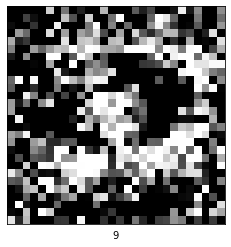

In [24]:
img = y_0.reshape((28, 28))

print(test_lab[index])
N = int(test_lab[index])

plt.figure(3)
plt.imshow(img, vmin=0, vmax=1, cmap="Greys")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlabel("${}$".format(N))
plt.savefig("deep_dream_{}.png".format(N))
plt.show()

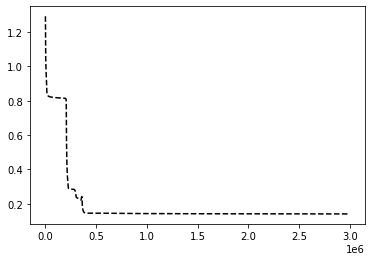

In [28]:
## plot residual while deep dreaming
residual = open("grafi/residual_deep_dream.txt", 'a')
print("step\tresidual", file=residual)
for i in range(len(h_0)):
    print(i, h_0[i], sep='\t', file=residual)
plt.plot(h_0, "k--")
plt.show()